In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f


from dotenv import load_dotenv
load_dotenv()

True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = data_root + "data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = data_root + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

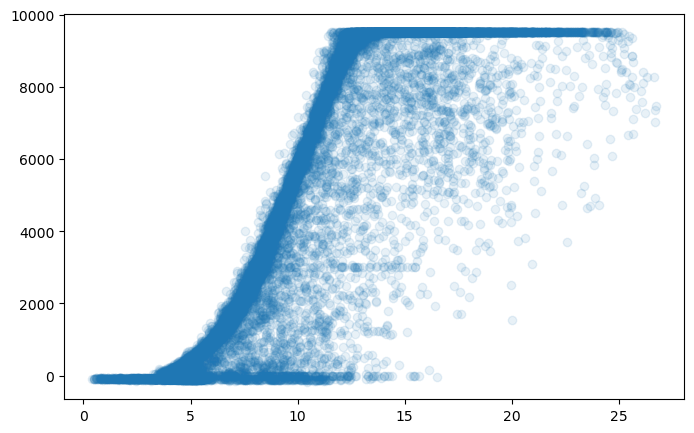

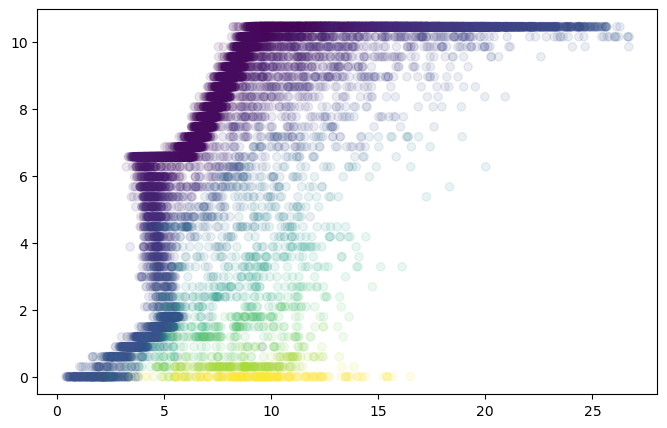

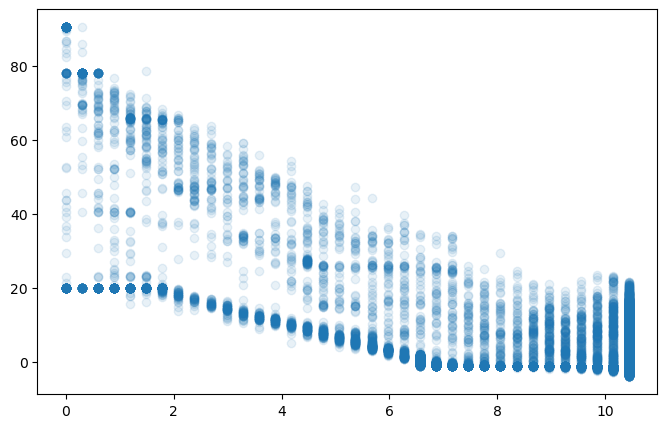

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(inputs['mean_NW2_D01_windspeed'], inputs['mean_NW2_D01_power'], alpha=0.1)
plt.show()
plt.figure(figsize=(8,5))
plt.scatter(inputs['mean_NW2_D01_windspeed'], inputs['mean_NW2_D01_rpm'], alpha=0.1, c=inputs['mean_NW2_D01_pitch'])
plt.show()
plt.figure(figsize=(8,5))
plt.scatter(inputs['mean_NW2_D01_rpm'], inputs['mean_NW2_D01_pitch'], alpha=0.1)
plt.show()

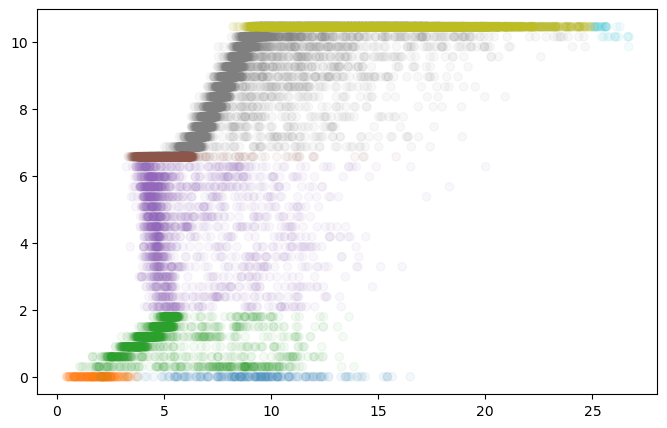

In [61]:
# define the 6 operational cases

import numpy as np

inputs['operational_case'] = np.nan

cutout_windspeed = 25
pitch1 = 72
rpm1 = 1.9
rpm2 = 6.5
rpm3 = 6.8
rpm4 = 10.2

# Case 1: parked/idling + pitch > 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] <= 0) & (inputs['mean_NW2_D01_pitch'] > pitch1) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    1,
    inputs['operational_case']
)

# Case 2: parked/idling + pitch < 72
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] <= 0) & (inputs['mean_NW2_D01_pitch'] < pitch1) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    2,
    inputs['operational_case']
)

# Case 3: transition1: 0 < rpm < 1.9
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] > 0) & (inputs['mean_NW2_D01_rpm'] < rpm1) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    3,
    inputs['operational_case']
)

# Case 4: transition2: 0 < rpm < 6.8
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] > rpm1) & (inputs['mean_NW2_D01_rpm'] < rpm2) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    4,
    inputs['operational_case']
)

# Case 5: start operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] >= rpm2) & (inputs['mean_NW2_D01_rpm'] < rpm3) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    5,
    inputs['operational_case']
)

# Case 6: operating: rpm where pitch increases
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] >= rpm3) & (inputs['mean_NW2_D01_rpm'] < rpm4) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    6,
    inputs['operational_case']
)

# Case 7: operating: rpm > rpm4
inputs['operational_case'] = np.where(
    (inputs['mean_NW2_D01_rpm'] >= rpm4) & (inputs['mean_NW2_D01_windspeed'] < cutout_windspeed),
    7,
    inputs['operational_case']
)

# Case 8: cutout: windspeed > cutout_windspeed
inputs['operational_case'] = np.where(
    inputs['mean_NW2_D01_windspeed'] > cutout_windspeed,
    8,
    inputs['operational_case']
)


plt.figure(figsize=(8,5))
plt.scatter(inputs['mean_NW2_D01_windspeed'], inputs['mean_NW2_D01_rpm'], alpha=0.05, c=inputs['operational_case'], cmap='tab10')
plt.show()

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
mode = 'SS1'
df = inputs.copy().dropna()
random_state = 24
test_size = 0.2

operational_cases = df['operational_case'].unique()

# Train Linear Regression Models for Each Case

linear_regression_models = {}
predictions = {}
r2 = {}
mean_squared_errors = {}
y = prediction_params[mode].dropna()
common_indices = df.index.intersection(y.index)
df_case = df.loc[common_indices]

for case in operational_cases:
    print(case)
    
    # Filter the dataset for the current operational case
    case_data = df_case[df_case['operational_case'] == case]
    
    # Split the data into input features (X) and target variable (y)
    y = prediction_params[mode].dropna()
    X = case_data.drop(['operational_case'], axis=1).dropna()
    y = y.loc[X.index]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Train a linear regression model for the current case
    linear_regression = LinearRegression()
    linear_regression.fit(X, y)
    
    # Store the trained linear regression model for the current case
    linear_regression_models[case] = linear_regression
    predictions[case] = linear_regression_models[case].predict(X_test)
    
    r2[case] = r2_score(y_test, predictions[case])
    mean_squared_errors[case] = mean_squared_error(y_test, predictions[case])
    print('R2: ', r2[case], 'MSE: ', mean_squared_errors[case])

# Calculate the overall R2 and MSE for the linear regression model through weighted averaging
r2_overall = 0
mse_overall = 0
for case in operational_cases:
    r2_overall += r2[case] * len(df_case[df_case['operational_case'] == case])
    mse_overall += mean_squared_errors[case] * len(df_case[df_case['operational_case'] == case])
r2_overall /= len(df_case)
mse_overall /= len(df_case)

print('Overall R2: ', r2_overall)
print('Overall MSE: ',mse_overall)

7.0
R2:  0.3073800130631038 MSE:  8.521636194531523e-06
8.0
R2:  1.0 MSE:  1.7850186380294955e-28
6.0
R2:  0.1598038880283349 MSE:  5.995936372239148e-06
4.0
R2:  0.2271919198430572 MSE:  2.388528390185148e-06
3.0
R2:  0.27406334419924594 MSE:  2.461391407985132e-06
5.0
R2:  0.1852509479569785 MSE:  2.6672358615115084e-06
2.0
R2:  0.12947890954610441 MSE:  4.13822576319122e-06
1.0
R2:  1.0 MSE:  3.0814879110195774e-33
Overall R2:  0.23866933242686578
Overall MSE:  6.040047122364426e-06


In [63]:
mode = 'SS1'
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

y = prediction_params[mode].dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 


In [6]:
# Step 3: Import the Required Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Multivariate Linear Regression
# 6 operational conditions: https://sci-hub.ru/10.1002/stc.2238

In [20]:
# Initialize the models
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
neural_network = MLPRegressor()
random_forest = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor()

input_dim = X_train.shape[1]
nn_regressor = Sequential()
nn_regressor.add(Dense(64, activation='relu', input_shape=(input_dim,)))  # Input layer
nn_regressor.add(Dense(64, activation='relu'))  # Hidden layer
nn_regressor.add(Dense(1))  # Output layer

nn_regressor.compile(optimizer='adam', loss='mse')  # Configure the model

# Train the models
linear_regression.fit(X_tr_prep, y_train)
decision_tree.fit(X_train, y_train)
neural_network.fit(X_tr_prep, y_train)
random_forest.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)
nn_regressor.fit(X_tr_prep, y_train, epochs=50, batch_size=32)  # Train the model

# Evaluate the models
linear_regression_pred = linear_regression.predict(X_test_prep)
decision_tree_pred = decision_tree.predict(X_test)
neural_network_pred = neural_network.predict(X_test_prep)
random_forest_pred = random_forest.predict(X_test)
xgb_regressor_pred = xgb_regressor.predict(X_test)
nn_regressor_pred = nn_regressor.predict(X_test_prep)

Epoch 1/50
407/407 [==============================] - 1s 1ms/step - loss: 0.0025
Epoch 2/50
407/407 [==============================] - 0s 1ms/step - loss: 3.8845e-04
Epoch 3/50
407/407 [==============================] - 0s 1ms/step - loss: 2.3326e-04
Epoch 4/50
407/407 [==============================] - 1s 1ms/step - loss: 1.6850e-04
Epoch 5/50
407/407 [==============================] - 0s 1ms/step - loss: 1.3076e-04
Epoch 6/50
407/407 [==============================] - 0s 1ms/step - loss: 1.1399e-04
Epoch 7/50
407/407 [==============================] - 0s 1ms/step - loss: 8.4358e-05
Epoch 8/50
407/407 [==============================] - 0s 1ms/step - loss: 7.2114e-05
Epoch 9/50
407/407 [==============================] - 0s 1ms/step - loss: 6.1259e-05
Epoch 10/50
407/407 [==============================] - 1s 1ms/step - loss: 5.1831e-05
Epoch 11/50
407/407 [==============================] - 0s 1ms/step - loss: 4.5666e-05
Epoch 12/50
407/407 [==============================] - 0s 1ms/step 

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
# Compute the relevant metrics
linear_regression_mse = mean_squared_error(y_test, linear_regression_pred)
decision_tree_mse = mean_squared_error(y_test, decision_tree_pred)
neural_network_mse = mean_squared_error(y_test, neural_network_pred)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
xgb_regressor_mse = mean_squared_error(y_test, xgb_regressor_pred)
nn_regressor_mse = mean_squared_error(y_test, nn_regressor_pred)

linear_regression_r2 = r2_score(y_test, linear_regression_pred)
decision_tree_r2 = r2_score(y_test, decision_tree_pred)
neural_network_r2 = r2_score(y_test, neural_network_pred)
random_forest_r2 = r2_score(y_test, random_forest_pred)
xgb_regressor_r2 = r2_score(y_test, xgb_regressor_pred)
nn_regressor_r2 = r2_score(y_test, nn_regressor_pred)

# Print the metrics
print("Linear Regression MSE:", linear_regression_mse, "R2:", linear_regression_r2)
print("Decision Tree MSE:", decision_tree_mse, "R2:", decision_tree_r2)
print("Neural Network MSE:", neural_network_mse, "R2:", neural_network_r2)
print("Random Forest MSE:", random_forest_mse, "R2:", random_forest_r2)
print("XGB Regressor MSE:", xgb_regressor_mse, "R2:", xgb_regressor_r2)
print("NN Regressor MSE:", nn_regressor_mse, "R2:", nn_regressor_r2)

Linear Regression MSE: 6.075622133636208e-06 R2: 0.23181730927671917
Decision Tree MSE: 1.112868022781262e-05 R2: -0.40707557737525946
Neural Network MSE: 0.0004015607260804147 R2: -49.77208428441705
Random Forest MSE: 5.894538368151148e-06 R2: 0.25471297512902646
XGB Regressor MSE: 5.969041507014552e-06 R2: 0.24529303089606158
NN Regressor MSE: 5.759518728287143e-06 R2: 0.2717844367785258


In [22]:
print(linear_regression.coef_)
print(inputs.columns)

[-0.00036571 -0.00018012 -0.00011433  0.00016203  0.00022469 -0.00123162
 -0.00095849 -0.00206806  0.00387439  0.00059025 -0.00068663 -0.00056244
  0.00057543]
Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')


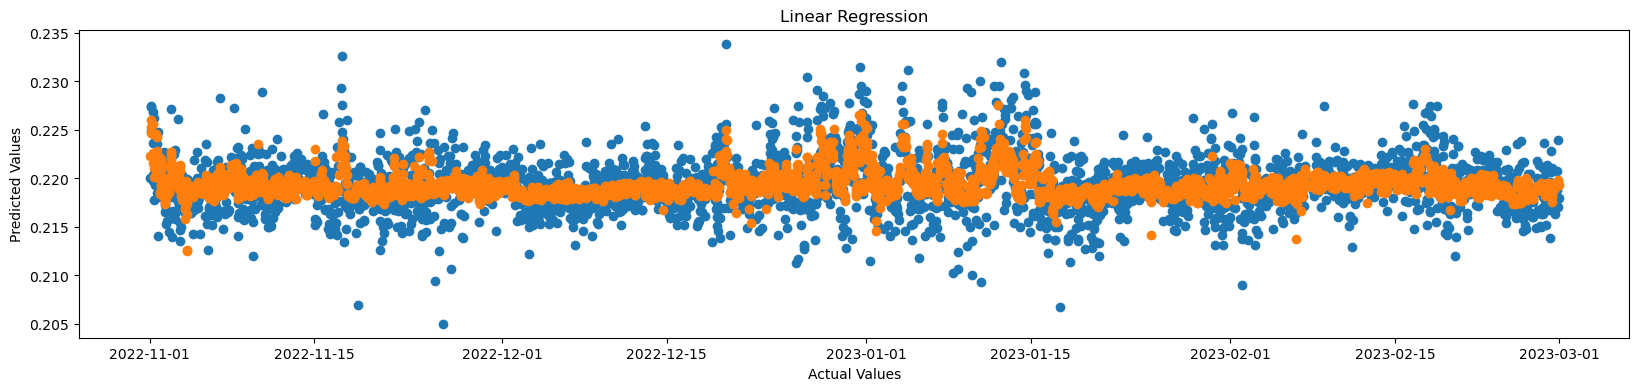

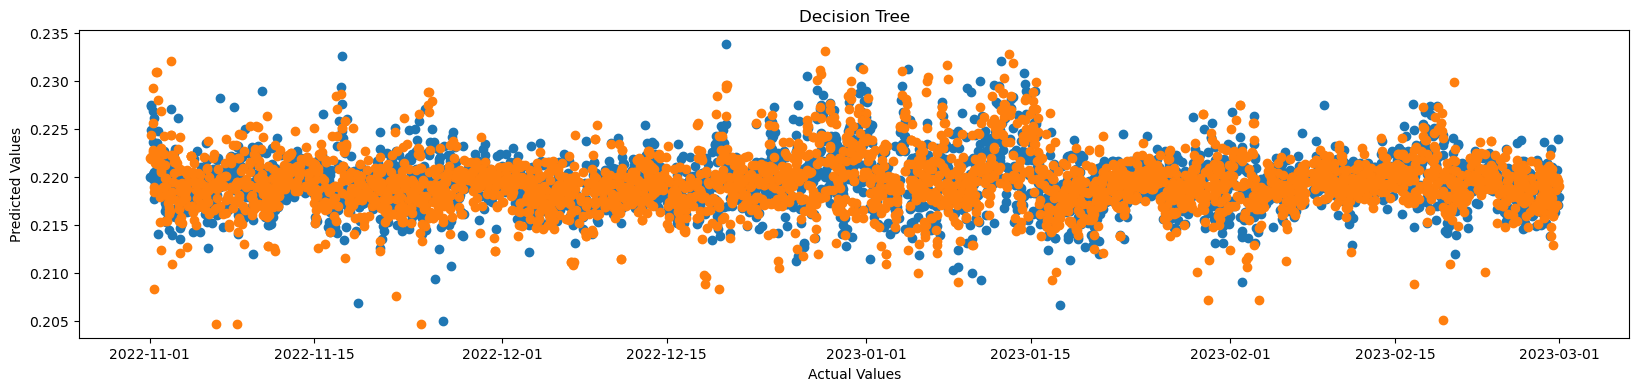

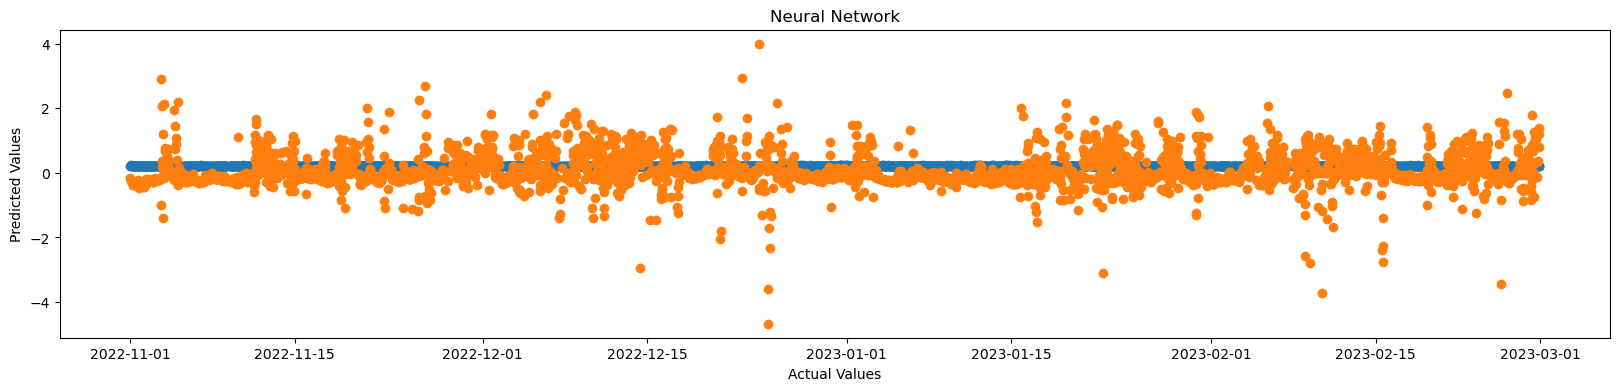

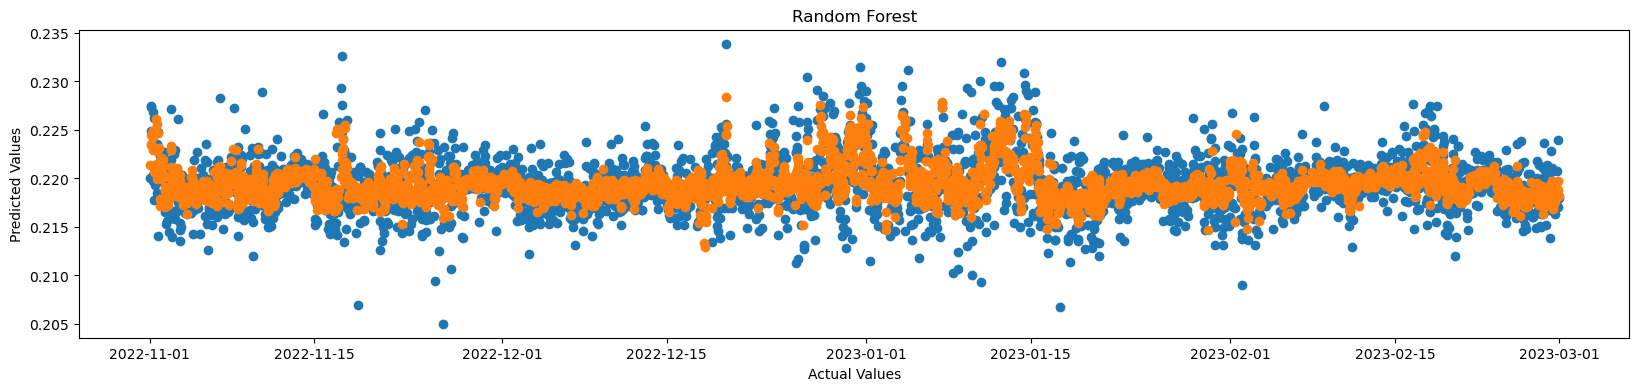

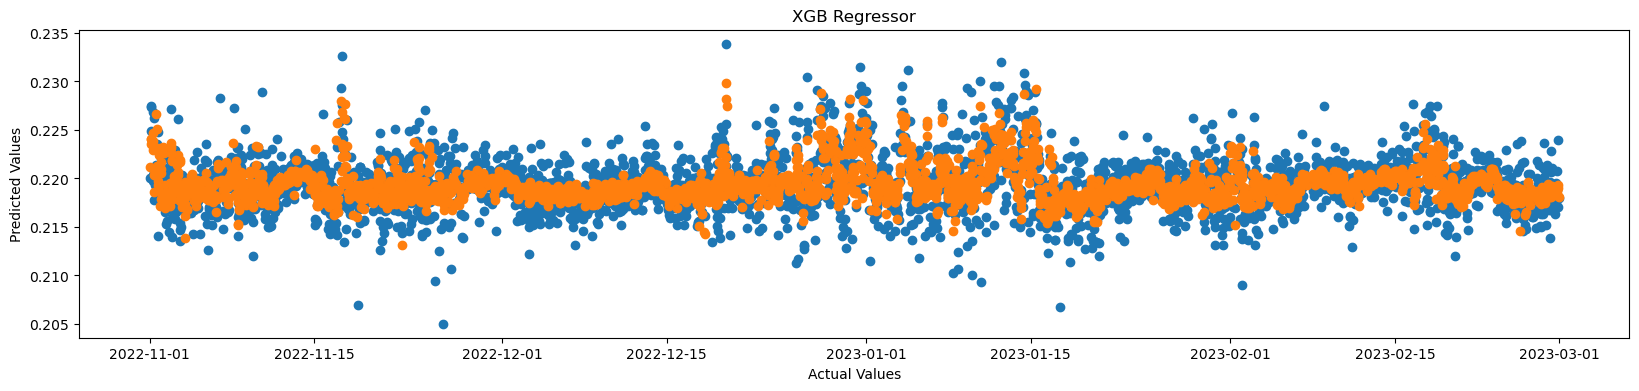

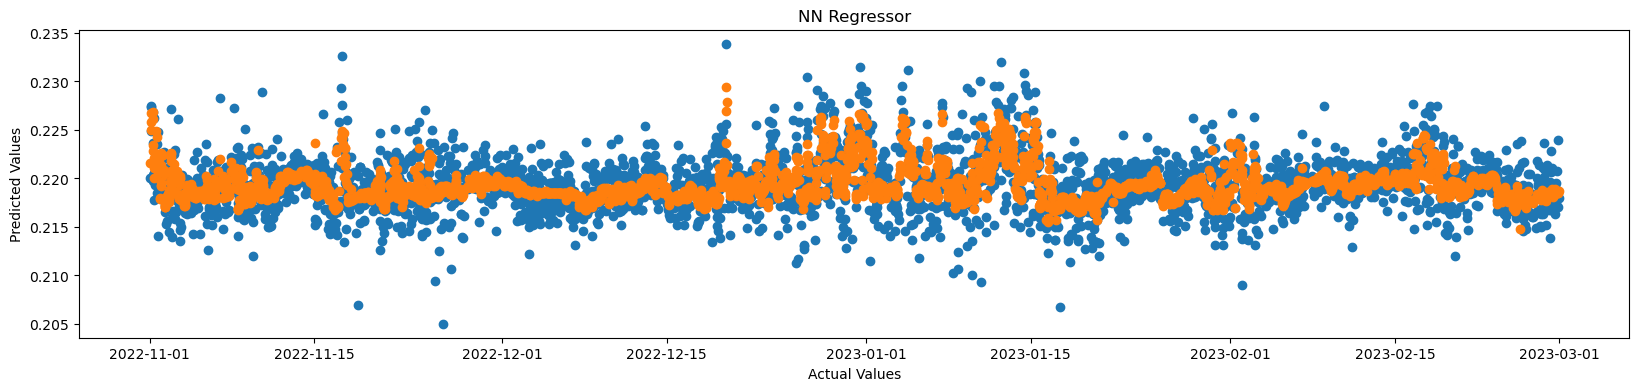

In [13]:
# Create scatter plot of predicted vs. actual values for linear regression
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, linear_regression_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()

# Create scatter plot of predicted vs. actual values for decision tree
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, decision_tree_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree')
plt.show()

# Create scatter plot of predicted vs. actual values for neural network
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, neural_network_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network')
plt.show()

# Create scatter plot of predicted vs. actual values for random forest
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, random_forest_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest')
plt.show()

# Create scatter plot of predicted vs. actual values for xgb regressor
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, xgb_regressor_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGB Regressor')
plt.show()

# Create scatter plot of predicted vs. actual values for nn regressor
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, nn_regressor_pred, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('NN Regressor')
plt.show()

### Optimize model hyperparameters with GridSearch

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, r2_score

In [15]:
# Define the scorer based on R2 score
scorer = make_scorer(r2_score)

In [26]:
#Perform Hyperparameter Optimization for RandomForestRegressor

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10], #[None, 5, 10]
    'min_samples_split': [5, 10, 20]
}

rf = RandomForestRegressor()

rf_grid = GridSearchCV(rf, rf_params, scoring='neg_mean_squared_error', cv=5)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
best_rf_mse = -rf_grid.best_score_

print("RandomForestRegressor Best Parameters:", rf_grid.best_params_)
print("RandomForestRegressor Best MSE:", best_rf_mse)

RandomForestRegressor Best Parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 300}
RandomForestRegressor Best MSE: 5.647914132141311e-06


In [31]:
#Hyperparameter optimization

#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from oma_tracking.models.utils import convert_dict
XGB_optimizations = {}

seed = 2
def objective_xgb(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='r2').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,500),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            rstate = np.random.default_rng(seed)
            )
    return best
        
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]
print(XGB_optimization)

regr_xgb_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', XGBRegressor(
                            n_estimators = XGB_optimizations[mode]['n_estimators'],
                            max_depth = XGB_optimizations[mode]['max_depth'],
                            learning_rate = XGB_optimizations[mode]['learning_rate'],
                            colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                            )
                        )
                    ]
                )

regr_xgb_optimized.fit(X_train, y_train)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test)
regr_xgb_optimized_mse = mean_squared_error(y_test, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

100%|██████████| 50/50 [06:37<00:00,  7.95s/trial, best loss: -0.2757572031204904] 


NameError: name 'XGB_optimization' is not defined

In [17]:
#Perform Hyperparameter Optimization for XGBRegressor

xgb_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}

xgb_reg = xgb.XGBRegressor()

xgb_grid = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=5)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
best_xgb_mse = -xgb_grid.best_score_

print("XGBRegressor Best Parameters:", xgb_grid.best_params_)
print("XGBRegressor Best MSE:", best_xgb_mse)

XGBRegressor Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBRegressor Best MSE: 5.606947156901331e-06


In [18]:
# Perform Hyperparameter Optimization for TensorFlow Neural Network
import keras_tuner
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=8, max_value=128, step=8),
            activation="relu",
        )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model


In [19]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mean_squared_error",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search_space_summary()


Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}


In [20]:
tuner.search(X_tr_prep, y_train, epochs=100, validation_data=(X_test_prep, y_test))

Trial 5 Complete [00h 03m 45s]
mean_squared_error: 5.719273758586496e-06

Best mean_squared_error So Far: 5.719273758586496e-06
Total elapsed time: 00h 17m 56s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
units: 120
Score: 5.719273758586496e-06
Trial summary
Hyperparameters:
units: 112
Score: 5.73058991903963e-06
Trial summary
Hyperparameters:
units: 88
Score: 5.841712663823273e-06
Trial summary
Hyperparameters:
units: 32
Score: 5.899421012145467e-06
Trial summary
Hyperparameters:
units: 16
Score: 6.610982609345228e-06


In [27]:
from sklearn.metrics import mean_squared_error, r2_score

best_rf_predictions = best_rf.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_predictions)
best_rf_r2 = r2_score(y_test, best_rf_predictions)
print("Random Forest MSE:", best_rf_mse, "R2:", best_rf_r2)


Random Forest MSE: 5.718830470227454e-06 R2: 0.26514816545280606


In [23]:
best_xgb = xgb_grid.best_estimator_
best_xgb.fit(X_train, y_train)
best_xgb_predictions = best_xgb.predict(X_test)
#best_nn_predictions = best_nn.predict(X_test)
                

# Compute the relevant metrics
best_xgb_mse = mean_squared_error(y_test, best_xgb_predictions)
#best_nn_mse = mean_squared_error(y_test, best_nn_predictions)

best_xgb_r2 = r2_score(y_test, best_xgb_predictions)
#best_nn_r2 = r2_score(y_test, best_nn_predictions)

# Print the metrics
print("XGB MSE:", best_xgb_mse, "R2:", best_xgb_r2)
#print("Neural Network MSE:", best_nn_mse, "R2:", best_nn_r2)

XGB MSE: 5.6975212187134e-06 R2: 0.2678863376454339


In [24]:
best_nn = tuner.get_best_models()[0]
best_nn_predictions = best_nn.predict(X_test_prep)
best_nn_mse = mean_squared_error(y_test, best_nn_predictions)
best_nn_r2 = r2_score(y_test, best_nn_predictions)
print("Neural Network MSE:", best_nn_mse, "R2:", best_nn_r2)

Neural Network MSE: 5.74229703511653e-06 R2: 0.2621327852366877


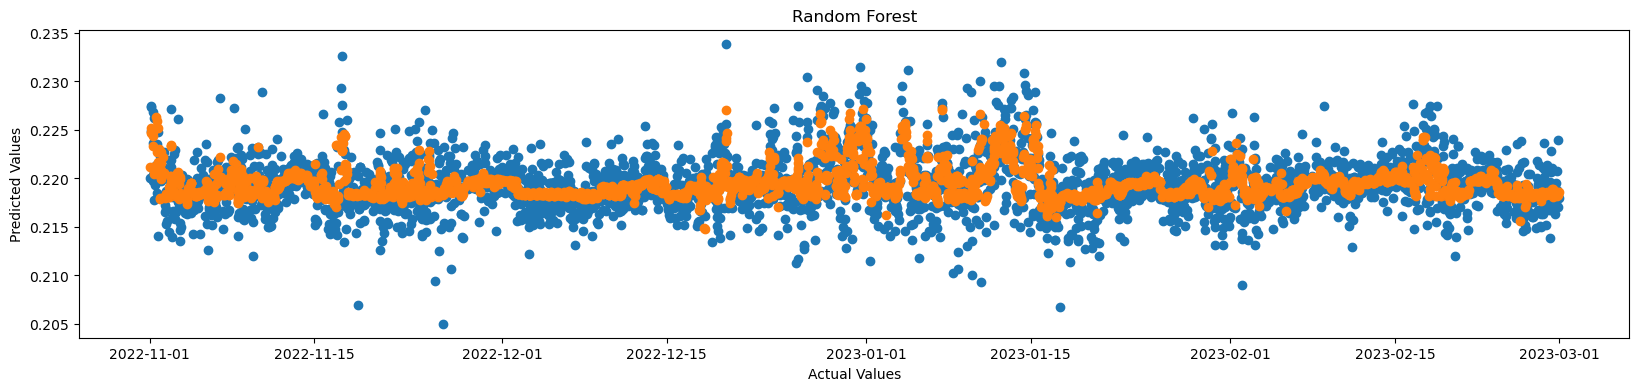

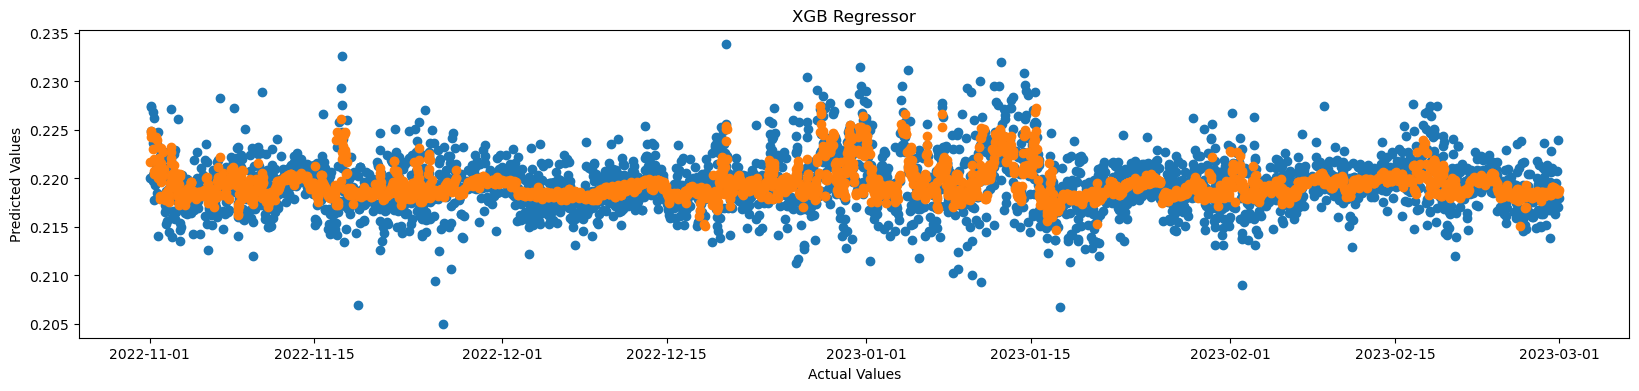

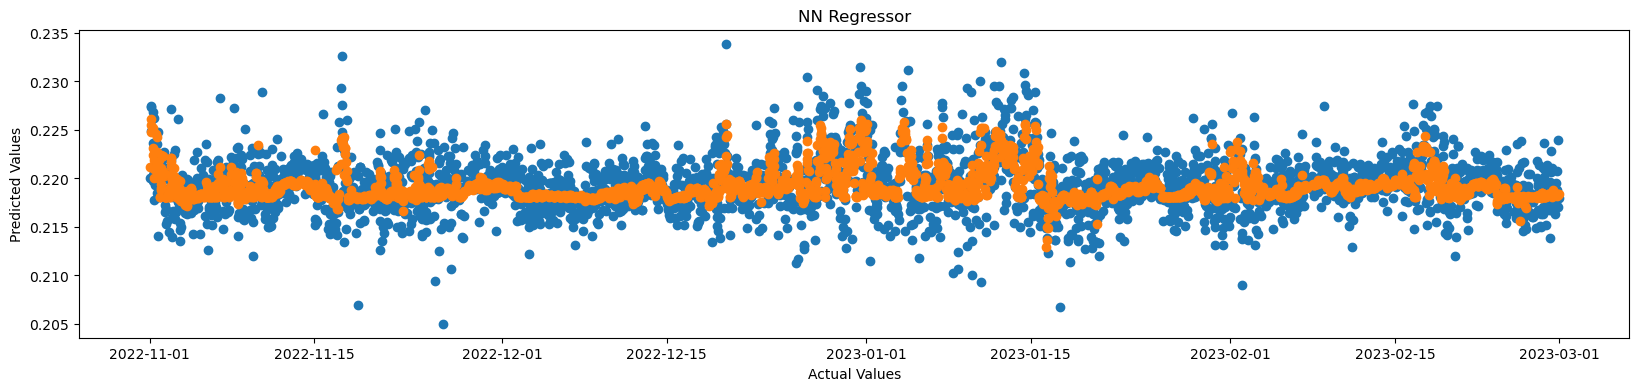

In [28]:
# Create scatter plot of predicted vs. actual values for best random forest

plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, best_rf_predictions, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest')
plt.show()

# Create scatter plot of predicted vs. actual values for best xgb regressor
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, best_xgb_predictions, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGB Regressor')
plt.show()


# Create scatter plot of predicted vs. actual values for best nn regressor
plt.figure(figsize=(20, 4))
plt.scatter(y_test.index, y_test, label='Actual Values')
plt.scatter(y_test.index, best_nn_predictions, label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('NN Regressor')
plt.show()


In [39]:
from functools import partial

#@title XGBQuantile Class
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

    
 

Gradient Boosting alpha = 0.05,score = 0.8
Gradient Boosting alpha = 0.95,score = 0.8


AttributeError: 'XGBQuantile' object has no attribute 'nthread'

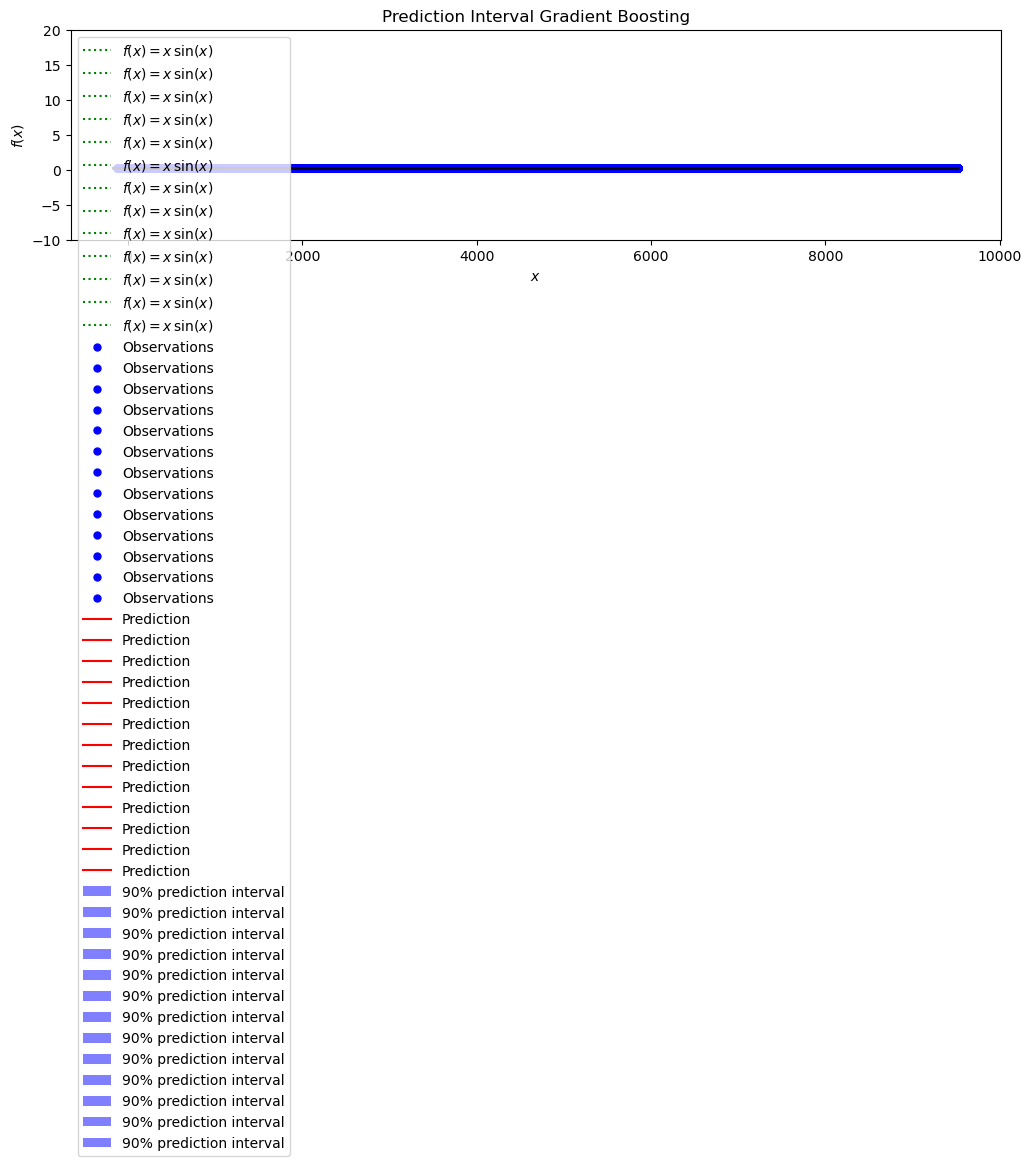

In [40]:
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
  estimator.fit(X_train,y_train)
  y_pred = estimator.predict(X_test)
  print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

  return y_pred

def plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower):
  
 
  plt.plot(X_test,y_test, 'g:', label=u'$f(x) = x\,\sin(x)$')
  plt.plot(X_train,y_train, 'b.', markersize=10, label=u'Observations')
  plt.plot(X_test, y_pred, 'r-', label=u'Prediction')
  plt.plot(X_test, y_upper, 'k-')
  plt.plot(X_test, y_lower, 'k-')
  plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.ylim(-10 , 20)
  plt.legend(loc='upper left')
  
alpha = 0.95 #@param {type:"number"}

#X_train,y_train,X_test,y_test = generate_data()


regressor = GradientBoostingRegressor(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
y_pred = regressor.fit(X_train,y_train).predict(X_test)
regressor.set_params(loss='quantile', alpha=1.-alpha)
y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Gradient Boosting")
regressor.set_params(loss='quantile', alpha=alpha)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Gradient Boosting")

                                                                 
fig = plt.figure(figsize=(12,6))

plt.subplot(211)
plt.title("Prediction Interval Gradient Boosting")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)


regressor = XGBRegressor(n_estimators=250,max_depth=3,reg_alpha=5, reg_lambda=1,gamma=0.5)
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor = XGBQuantile(n_estimators=100,max_depth = 3, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0 )     
regressor.set_params(quant_alpha=1.-alpha,quant_delta=1.0,quant_thres=5.0,quant_var=3.2)

y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Quantile XGB")
regressor.set_params(quant_alpha=alpha,quant_delta=1.0,quant_thres=6.0,quant_var = 4.2)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Quantile XGB")

plt.subplot(212)
plt.title("Prediction Interval XGBoost")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)
